In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("mouse_viral_study.csv")

In [3]:
df.head()

,Med_1_mL,Med_2_mL,Virus Present
0,6.508231,8.582531,0
1,4.126116,3.073459,1
2,6.427870,6.369758,0
3,3.672953,4.905215,1
4,1.580321,2.440562,1


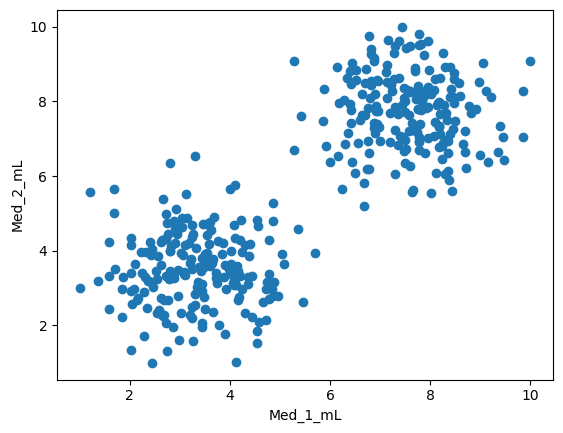

In [4]:
plt.plot(df["Med_1_mL"], df["Med_2_mL"], 'o')
plt.xlabel('Med_1_mL')
plt.ylabel('Med_2_mL')
plt.show()

In [5]:
# Séparation des données en variables explicatives et cible
X = df['Med_1_mL'].values.reshape(-1, 1)
y = df['Med_2_mL'].values.reshape(-1, 1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## BIC

In [7]:
# Détermination du degré optimal du polynôme en utilisant le critère BIC
max_degree = 20
bic_values = []
models = []

for degree in range(1, max_degree + 1):
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train)
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    num_params = X_train_poly.shape[1]
    y_train_pred = model.predict(X_train_poly)
    log_likelihood = -0.5 * len(X_train) * np.log(mean_squared_error(y_train, y_train_pred))
    bic = -2 * log_likelihood + num_params * np.log(len(X_train))
    bic_values.append(bic)
    models.append(model)

best_model_idx = np.argmin(bic_values)
best_model = models[best_model_idx]
best_degree = best_model_idx + 1

print(f"Best polynomial degree: {best_degree}")

Best polynomial degree: 9


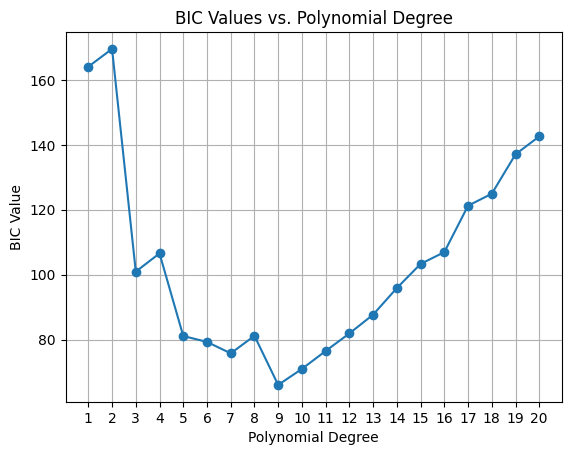

In [8]:
# Plot BIC values vs. polynomial degree
plt.plot(range(1, max_degree+1), bic_values, marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('BIC Value')
plt.title('BIC Values vs. Polynomial Degree')
plt.xticks(range(1, max_degree+1))
plt.grid(True)
plt.show()

In [9]:
def puiss(X,n):
    for i in range(0,n-1):
        product_column = np.multiply(X[:, 0], X[:, i])
        X = np.column_stack((product_column, X))
    print(X.shape)
    return X

In [10]:
X_train = puiss(X_train,17)
X_test = puiss(X_test,17)

(320, 17)
(80, 17)


### Mise à l'échelle des données

In [11]:
# scaler = StandardScaler()
# scaler.fit(X_train)
# means = scaler.mean_
# scales = np.sqrt(scaler.var_)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = (X_test - means)/scales
# print(X_train_scaled.shape)

#### Ajout d'une colonne de biais

In [25]:
ones_column = np.ones((X_train_scaled.shape[0], 1))
ones_column2 = np.ones((X_test_scaled.shape[0], 1))
X_train_scaled = np.hstack((X_train_scaled, ones_column))
X_test_scaled = np.hstack((X_test_scaled, ones_column2))
print(X_test_scaled.shape)
# ones_column = np.ones((X_train.shape[0], 1))
# ones_column2 = np.ones((X_test.shape[0], 1))
# X_train_scaled = np.hstack((X_train, ones_column))
# X_test_scaled = np.hstack((X_test, ones_column2))
# print(X_test_scaled.shape)

(80, 19)


In [26]:
def regression_multiple_from_scratch(X_train, y_train, X_test, y_test, n_iterations=400, learning_rate=0.09, regularization=None, alpha=0.001):
    np.random.seed(0)
    theta = np.random.randn(X_train.shape[1], 1)

    def model(X, theta):
        return X.dot(theta)

    def cost_function(X, y, theta, alpha=None):
        m = len(y)
        if alpha is None:
            return 1/(2*m) * np.sum((model(X, theta) - y)**2)
        else:
            return 1/(2*m) * np.sum((model(X, theta) - y)**2) + alpha/m * np.linalg.norm(theta, ord=1) if regularization == 'lasso' else alpha/(2*m) * np.sum(theta[1:]**2)

    def grad(X, y, theta, alpha=None):
        m = len(y)
        if alpha is None:
            return 1/m * X.T.dot(model(X, theta) - y)
        else:
            return 1/m * X.T.dot(model(X, theta) - y) + alpha/m * theta * np.sign(theta) if regularization == 'lasso' else 1/m * X.T.dot(model(X, theta) - y) + alpha/m * np.vstack((0, theta[1:]))

    def gradient_descent(X, y, theta, learning_rate, n_iterations, alpha=None):
        cost_history = np.zeros(n_iterations)
        for i in range(n_iterations):
            theta = theta - learning_rate * grad(X, y, theta, alpha)
            cost_history[i] = cost_function(X, y, theta, alpha)
        return theta, cost_history

    theta_final, cost_history = gradient_descent(X_train, y_train, theta, learning_rate, n_iterations, alpha)

    plt.plot(range(n_iterations), cost_history)
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.title('Cost Function vs. Iterations')
    plt.show()

    def coef_determination(y, pred):
        u = ((y - pred)**2).sum()
        v = ((y - y.mean())**2).sum()
        return 1 - u/v

    train_predictions = model(X_train, theta_final)
    test_predictions = model(X_test, theta_final)

    train_cd= coef_determination(y_train, train_predictions)
    test_cd = coef_determination(y_test, test_predictions)
    y_test_pred = model(X_test_scaled, theta_final)


    return train_cd, test_cd,y_test_pred




C:\Users\hp\AppData\Local\Temp\ipykernel_10884\3152124176.py:13: RuntimeWarning: overflow encountered in square
  return 1/(2*m) * np.sum((model(X, theta) - y)**2) + alpha/m * np.linalg.norm(theta, ord=1) if regularization == 'lasso' else alpha/(2*m) * np.sum(theta[1:]**2)
C:\Users\hp\AppData\Local\Temp\ipykernel_10884\3152124176.py:25: RuntimeWarning: invalid value encountered in subtract
  theta = theta - learning_rate * grad(X, y, theta, alpha)


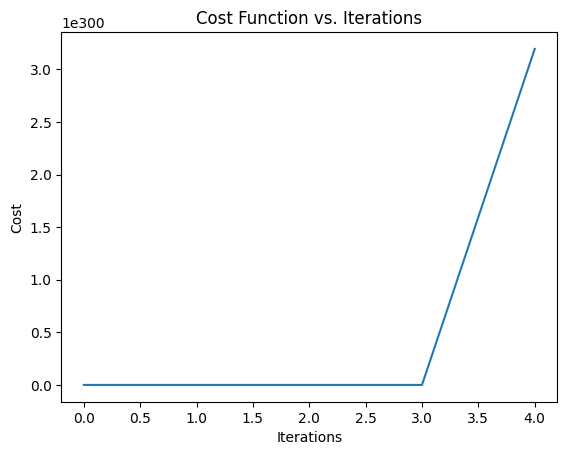

ValueError: shapes (80,19) and (17,1) not aligned: 19 (dim 1) != 17 (dim 0)

In [27]:
train_cd, test_cd = regression_multiple_from_scratch(X_train, y_train, X_test, y_test)
print("Coefficient de détermination sur les données d'entraînement:", train_cd)
print("Coefficient de détermination sur les données de test:", test_cd)

In [16]:
train_cd, test_cd, y_test_pred = regression_multiple_from_scratch(X_train_scaled, y_train, X_test_scaled, y_test, regularization='lasso', alpha=0.0001)
print("Coeff d'entrainement:", train_cd)
print("Coeff de test", test_cd)

UnboundLocalError: cannot access local variable 'cost_history' where it is not associated with a value

In [ ]:
# # Polynomial feature transformation
# poly = PolynomialFeatures(degree=17)
# X_train_poly = poly.fit_transform(X_train)
# X_test_poly = poly.transform(X_test)
X_train_poly = X_train
X_test_poly = X_test

#### Affichage de l'erreur RMSE en fonction du degré du modèle polynomial


In [ ]:
train_rmse_errors = []
test_rmse_errors = []

for d in range(1, 20):
    polynomial_converter = PolynomialFeatures(degree=d, include_bias=True)
    X_poly_train = polynomial_converter.fit_transform(X_train)
    X_poly_test = polynomial_converter.transform(X_test)
    model = LinearRegression(fit_intercept=True)
    model.fit(X_poly_train, y_train)
    train_pred = model.predict(X_poly_train)
    test_pred = model.predict(X_poly_test)
    train_RMSE = np.sqrt(mean_squared_error(y_train, train_pred))
    test_RMSE = np.sqrt(mean_squared_error(y_test, test_pred))
    train_rmse_errors.append(train_RMSE)
    test_rmse_errors.append(test_RMSE)

#### R2 des modèles polynomial standard


In [ ]:
r2_test_standard = r2_score(y_test, test_pred)
print('Test R2 (standard):', r2_test_standard)

### Calcul des métriques d'évaluation pour le modèle polynomial standard


In [ ]:
MAE_standard = mean_absolute_error(y_test, test_pred)
MSE_standard = mean_squared_error(y_test, test_pred)
RMSE_standard = np.sqrt(MSE_standard)
print('MAE (standard):', MAE_standard)
print('MSE (standard):', MSE_standard)
print('RMSE (standard):', RMSE_standard)

#### Visualisation des prédictions sur l'ensemble de test par rapport aux valeurs réelles pour le modèle polynomial standard

In [ ]:
plt.plot(y_test, 'o', label='y_test')
plt.plot(test_pred, 'o', label='y_test_pred (standard)')
plt.xlabel('Exemples')
plt.ylabel('Largeur')
plt.title('Prédictions sur l\'ensemble de test par rapport aux valeurs réelles (modèle polynomial standard)')
plt.legend()
plt.show()

### Affichage de RMSE en fct du degré du modèle polynomial pour le modèle polynomial standard

In [ ]:
plt.plot(range(1, 20), train_rmse_errors, label='TRAIN (standard)')
plt.plot(range(1, 20), test_rmse_errors, label='TEST (standard)')
plt.xlabel("Complexité Polynomiale")
plt.ylabel("RMSE")
plt.title('Évolution de l\'erreur RMSE en fonction du degré du modèle polynomial (standard)')
plt.legend()
plt.show()

### Régularisation LASSO pour corriger l'overfitting


In [ ]:
lasso_model = Lasso(alpha=0.001)  # Réglage du paramètre alpha
lasso_model.fit(X_poly_train, y_train)
lasso_test_predictions = lasso_model.predict(X_poly_test)

### Calcul et affichage des métriques d'évaluation pour LASSO

In [ ]:
MAE_lasso = mean_absolute_error(y_test, lasso_test_predictions)
MSE_lasso = mean_squared_error(y_test, lasso_test_predictions)
RMSE_lasso = np.sqrt(MSE_lasso)
print('LASSO MAE:', MAE_lasso)
print('LASSO MSE:', MSE_lasso)
print('LASSO RMSE:', RMSE_lasso)

### Visualisation des prédictions pour LASSO par rapport aux valeurs réelles

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lasso_test_predictions, color='blue', label='LASSO Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Predictions')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('LASSO Model Predictions vs. True Values')
plt.legend()
plt.show()

### Régularisation RIDGE pour corriger l'overfitting


In [ ]:
ridge_model = Ridge(alpha=0.001)  # Réglage du paramètre alpha
ridge_model.fit(X_poly_train, y_train)
ridge_test_predictions = ridge_model.predict(X_poly_test)

### Calcul et affichage des métriques d'évaluation pour RIDGE


In [ ]:
MAE_ridge = mean_absolute_error(y_test, ridge_test_predictions)
MSE_ridge = mean_squared_error(y_test, ridge_test_predictions)
RMSE_ridge = np.sqrt(MSE_ridge)
print('RIDGE MAE:', MAE_ridge)
print('RIDGE MSE:', MSE_ridge)
print('RIDGE RMSE:', RMSE_ridge)

### Visualisation des prédictions pour RIDGE par rapport aux valeurs réelles


In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, ridge_test_predictions, color='green', label='RIDGE Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Predictions')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('RIDGE Model Predictions vs. True Values')
plt.legend()
plt.show()